#### Flight Cancelled Helper
- Imagine your flight has been cancelled
- you need: 
  - a new flight
  - If this is for another day (not today) you'll also need a hotel

In [9]:
import json
from typing import TypedDict, Optional, Annotated, Literal
import operator
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from pydantic import BaseModel, Field

from dotenv import load_dotenv   # from the python-dotenv library - load the OpenAI API key from file
load_dotenv(dotenv_path='../../../.env', override=True)

True

In [10]:
# 1. State Definition
class TravelState(TypedDict):
    user_request: str
    command: Optional[str]
    flight_info: Optional[dict]
    hotel_info: Optional[dict]
    # 'operator.add' allows us to keep a running log of the conversation
    history: Annotated[list, operator.add] 


class PlannerAction(BaseModel):
    """Decide the next step in the travel recovery process."""
    command: Literal["find_flight", "book_hotel", "finalize"] = Field(
        description="The specific tool or action the worker should perform next."
    )
    reasoning: str = Field(description="Brief explanation of why this step was chosen.")

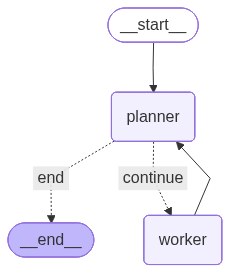

In [11]:
# 2. The Planner Node (The Brain)
llm = ChatOpenAI(model="gpt-4o", temperature=0)
planner_llm = llm.with_structured_output(PlannerAction)

def planner(state: TravelState):
    prompt = f"""
    You are the Manager. Goal: {state['user_request']}
    Current Data: Flight={state.get('flight_info')}, Hotel={state.get('hotel_info')}

    Instructions:
    - If no flight: {{"command": "find_flight"}}
    - If flight arrives after 20:00 AND no hotel: {{"command": "book_hotel"}}
    - Otherwise: {{"command": "finalize"}}

    Respond ONLY in JSON.
    """
    decision = planner_llm.invoke(prompt)
    
    return {
        "command": decision.command,
        "history": [f"STRATEGIST: {decision.reasoning} -> Action: {decision.command}"]
    }

# 3. The Busy Bee Node (The Worker)
def worker(state: TravelState):
    cmd = state["command"]
    
    if cmd == "find_flight":
        # Simulate tool output: arrives late at 22:00
        result = {"flight": "UX-99", "arrival": "19:00"}
        return {"flight_info": result, "history": ["Worker: Found late flight UX-99"]}
    
    if cmd == "book_hotel":
        result = {"hotel": "Midnight Inn", "status": "booked"}
        return {"hotel_info": result, "history": ["Worker: Booked the Midnight Inn"]}
    
    return {"history": ["Bee: Nothing to do"]}

# 4. Logic Router
def router(state: TravelState):
    if state["command"] == "finalize":
        return "end"
    return "continue"

# 5. Build and Compile
builder = StateGraph(TravelState)

builder.add_node("planner", planner)
builder.add_node("worker", worker)

builder.set_entry_point("planner")

builder.add_conditional_edges(
    "planner",
    router,
    {"continue": "worker", "end": END}
)

builder.add_edge("worker", "planner") # The Loop

app = builder.compile()

app

In [12]:
# 6. Run with Invoke
final_result = app.invoke({
    "user_request": "I'm flying to Tokyo tonight", 
    "history": []
})

print(f"Final Status: {final_result['history'][-1]}")

Final Status: STRATEGIST: The flight is already booked and arrives at 19:00, which is before the 20:00 threshold. There is no need to book a hotel as per the given instructions. -> Action: finalize
